In [69]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import curve_fit
import datetime

## Read the file

In [70]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion3, ion3_raw, ion3_bottom, ion3_top, ion4, ion4_raw, ion4_bottom, ion4_top, \
    ion5, ion5_raw, ion5_bottom, ion5_top, ion2, ion2_raw, ion2_bottom, ion2_top, ion6, ion6_raw, ion6_bottom, \
    ion6_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, 
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion4

In [71]:
class DressedState:
    def __init__(self, 
                 E0 = 0,
                 E1 = 0,
                 E2 = 0,
                 E3 = 0,
                 w1 = 0,
                 w2 = 0,
                 omega01 = 0,
                 omega02 = 0,
                 omega03 = 0,
                 omega12 = 0,
                 omega13 = 0,
                 gamma1 = 0,
                 gamma2 = 0,
                 gamma3 = 0,
                 s_init = ket2dm(basis(4,0))
                ):
        self.E0 = E0
        self.E1 = E1
        self.E2 = E2
        self.E3 = E3
        self.w1 = w1
        self.w2 = w2
        self.omega01 = omega01
        self.omega02 = omega02
        self.omega03 = omega03
        self.omega12 = omega12
        self.omega13 = omega13
        self.gamma1 = gamma1
        self.gamma2 = gamma2
        self.gamma3 = gamma3
        self.s_init = s_init
        self.output = None
        
    def solve(self, tlist):
        H0 = self.E0 * basis(4,0) * basis(4,0).dag()\
            + self.E1 * basis(4,1)* basis(4,1).dag() \
            + self.E2 * basis(4,2)* basis(4,2).dag()\
            + self.E3 * basis(4,3)* basis(4,3).dag()
        
        H_01_10 = self.omega01*basis(4,0)*basis(4,1).dag() + np.conj(self.omega01)*basis(4,1)*basis(4,0).dag()
        
        H_02 = self.omega02*basis(4,0) * basis(4,2).dag()
        def H_02_coeff(t, args):
            return np.exp(-1j*self.w2*t)
        
        H_20 = np.conj(self.omega02)*basis(4,2) * basis(4,0).dag()
        def H_20_coeff(t, args):
            return np.exp(1j*self.w2*t)
        
        H_03 = self.omega03*basis(4,0) * basis(4,3).dag()
        def H_03_coeff(t, args):
            return np.exp(1j*self.w2*t)
        
        H_30 = np.conj(self.omega03)*basis(4,3) * basis(4,0).dag()
        def H_30_coeff(t, args):
            return np.exp(-1j*self.w2*t)
        
        H_12_21 = self.omega12*basis(4,1)*basis(4,2).dag() + np.conj(self.omega12)*basis(4,2)*basis(4,1).dag()
        
        H_13 = self.omega13*basis(4,1) * basis(4,3).dag()
        def H_13_coeff(t, args):
            return np.exp(2*1j*self.w2*t)
        
        H_31 = np.conj(self.omega13)*basis(4,3) * basis(4,1).dag()
        def H_31_coeff(t, args):
            return np.exp(-2*1j*self.w2*t)
        
        
        H = [H0, H_01_10, [H_02, H_02_coeff], [H_20, H_20_coeff], [H_03, H_03_coeff], [H_30, H_30_coeff], \
            H_12_21, [H_13, H_13_coeff], [H_31, H_31_coeff]]
        
        c_ops = [np.sqrt(self.gamma1)*basis(4,1)* basis(4,1).dag(), 
                 np.sqrt(self.gamma2)*basis(4,2)* basis(4,2).dag(), 
                 np.sqrt(self.gamma3)*basis(4,3)* basis(4,3).dag()]
            
        e_ops = []
        
        opts = Options(normalize_output=False)
        self.output = mesolve(H, self.s_init, tlist, c_ops, e_ops, options = opts)
    
    def time_scan(self,
                  t_start,
                  t_stop,
                  Nsample,
                  isPlot = True
                 ):

        t_list = np.linspace(t_start, t_stop, Nsample)
        self.solve(t_list)
        states = self.output.states
        s0,s1,s2,s3= self.measure(states, self.output.times, isPlot)
        return s0,s1,s2,s3
    def measure(self, states, x_axis, isPlot = True):
        # states: np.array of dm includes two ions and phonons
        s_0 = basis(4, 0)*basis(4, 0).dag() # State 0
        s_1 = basis(4, 1)*basis(4, 1).dag() # State 1
        s_2 = basis(4, 2)*basis(4, 2).dag() # State 2
        s_3 = basis(4, 3)*basis(4, 3).dag() # State 3

        def _measure(state, s_meas):
            result = (state*s_meas).tr()
            return np.real(result)
            
        s0 = np.zeros(len(states))
        s1 = np.zeros(len(states))
        s2 = np.zeros(len(states))
        s3 = np.zeros(len(states))

        for i in range(len(states)):
            s0[i] = _measure(states[i], s_0)
            s1[i] = _measure(states[i], s_1)
            s2[i] = _measure(states[i], s_2)
            s3[i] = _measure(states[i], s_3)
        if isPlot:
            plt.figure(figsize = [10,6])
            plt.plot(x_axis, s0, label = 's0')
            plt.plot(x_axis, s1, label = 's1')
            plt.plot(x_axis, s2, label = 's2')
            plt.plot(x_axis, s3, label = 's3')
            plt.xlabel('Time (us)')
            plt.ylabel(r'Population')
            plt.legend()
            plt.ylim(-0.05,1.05)
            plt.show()
        return s0,s1,s2,s3

# Initial state 1

In [72]:
def error(_data):
    data = np.array(_data)
    return np.array(np.sqrt((np.sqrt(abs(data)*(1-abs(data))/100))**2+0.01**2))

0.0 0.0 0.0 -15.56


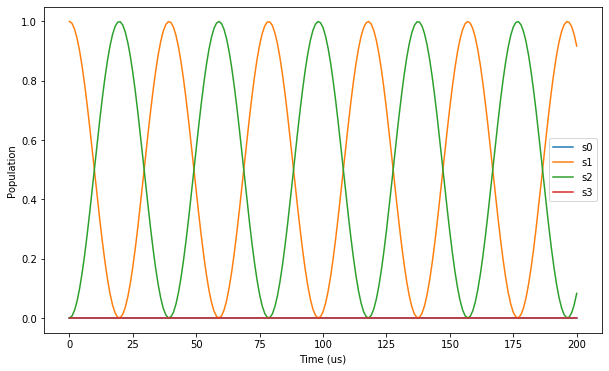

In [75]:
pi_time = 12.5 # us
omega = 1/pi_time # MHz
w01 = 12.628e3 # MHz
delta2 = 7.78
delta3 = 7.78
w1 = w01
w2 = delta2
Delta1 = w01-w1
Delta2 = delta2-w2
Delta3 = delta3+w2
E0 = 0.0
E1 = Delta1
E2 = Delta1+Delta2
E3 = Delta1-Delta3
print(E0, E1, E2, E3)
exp = DressedState(E0 = E0,
             E1 = E1,
             E2 = E2,
             E3 = E3,
             w1 = w1,
             w2 = w2,
             omega01 = 0,
             omega02 = 0,
             omega03 = 0,
             omega12 = omega,
             omega13 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,1)))
s0,s1,s2,s3 = exp.time_scan(0, 200, 201, isPlot = True)

detuning is  -8.558000000000902


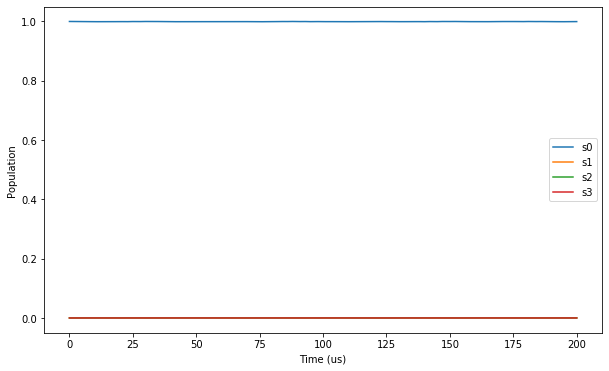

detuning is  -8.38684000000103


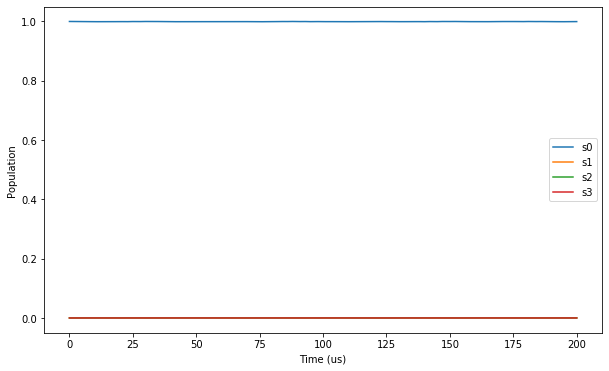

detuning is  -8.215680000001157


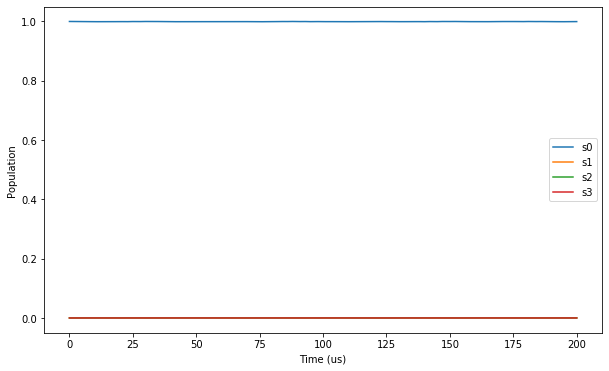

detuning is  -8.044520000001285


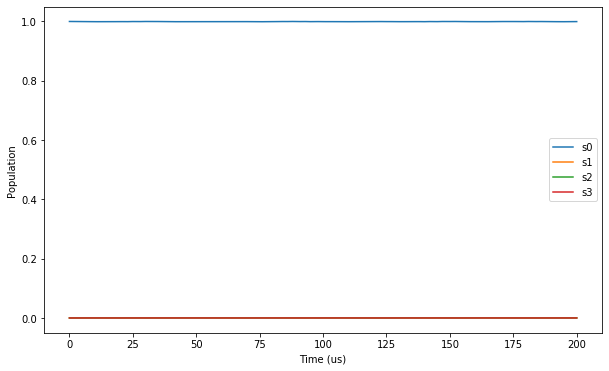

detuning is  -7.873360000001412


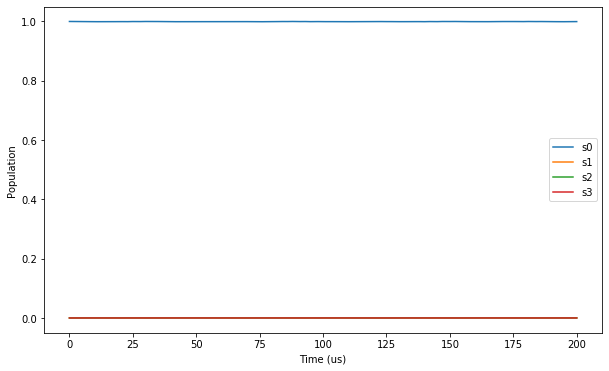

detuning is  -7.70220000000154


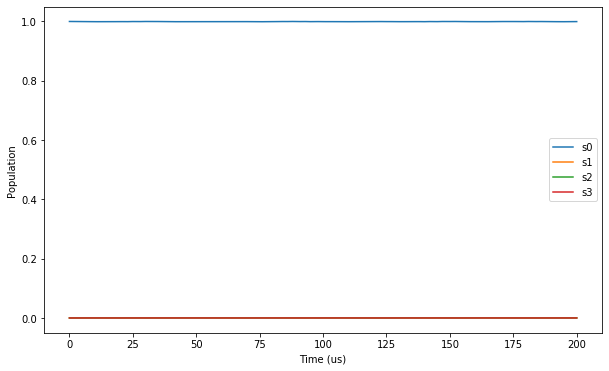

detuning is  -7.531040000001667


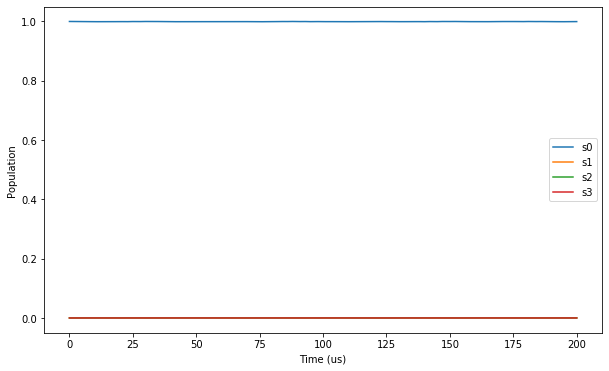

detuning is  -7.3598799999999756


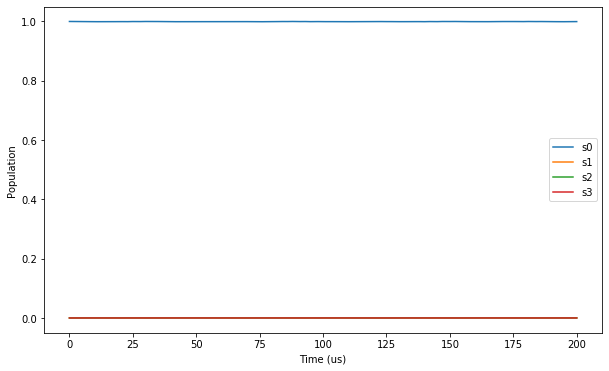

detuning is  -7.188720000000103


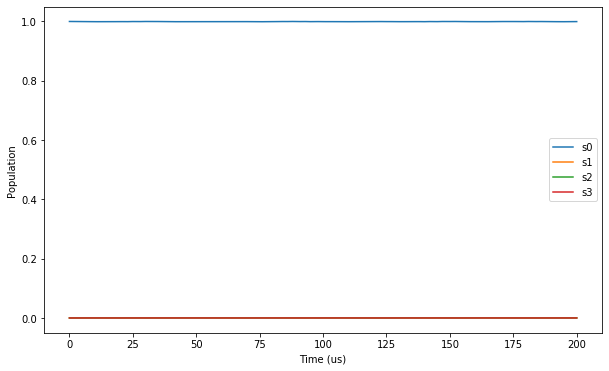

detuning is  -7.0175600000002305


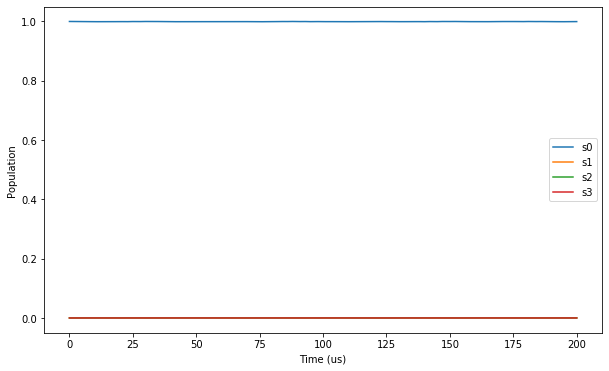

detuning is  -6.846400000000358


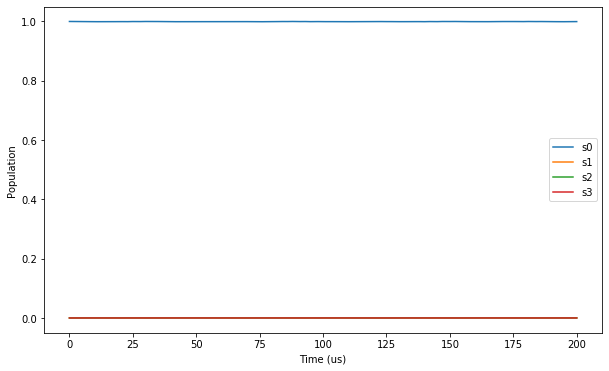

detuning is  -6.6752400000004855


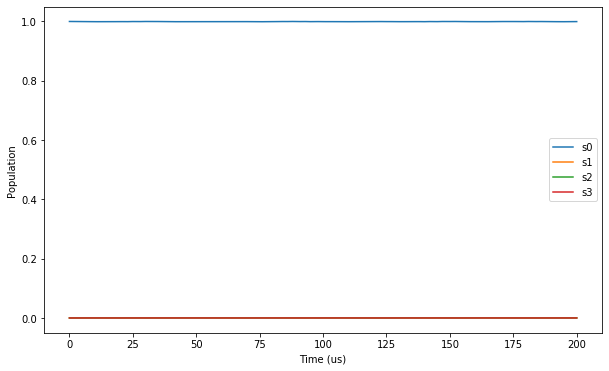

detuning is  -6.504080000000613


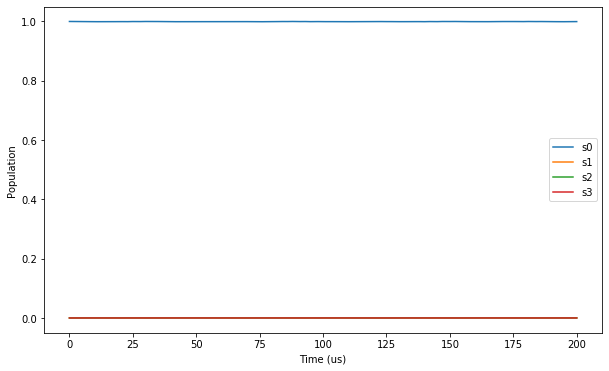

detuning is  -6.33292000000074


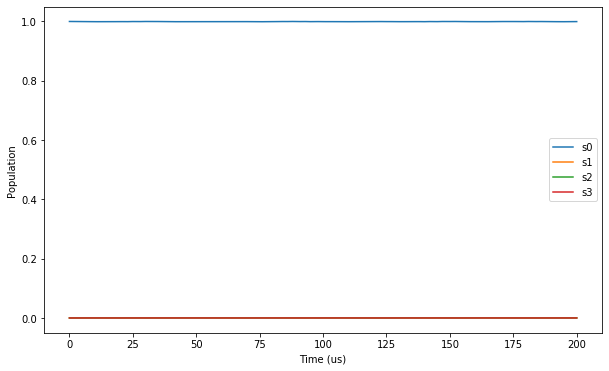

detuning is  -6.161760000000868


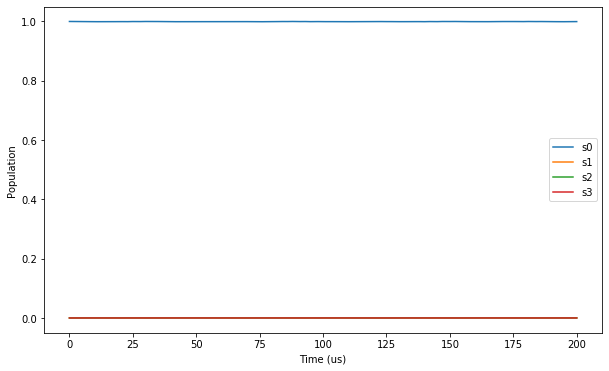

detuning is  -5.990600000000995


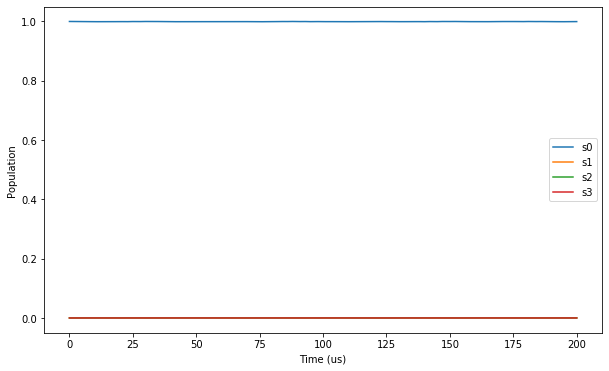

detuning is  -5.819440000001123


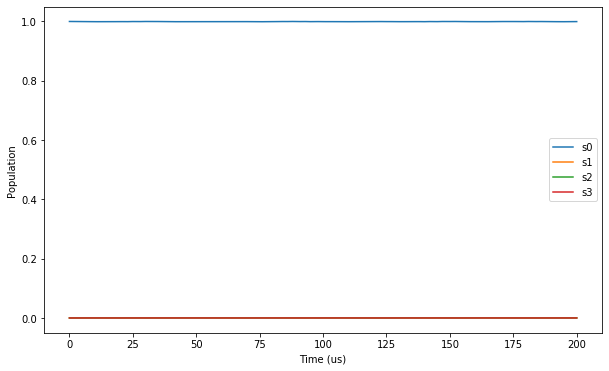

detuning is  -5.64828000000125


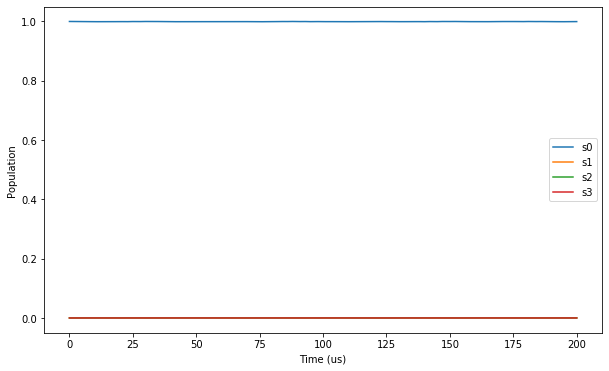

detuning is  -5.477120000001378


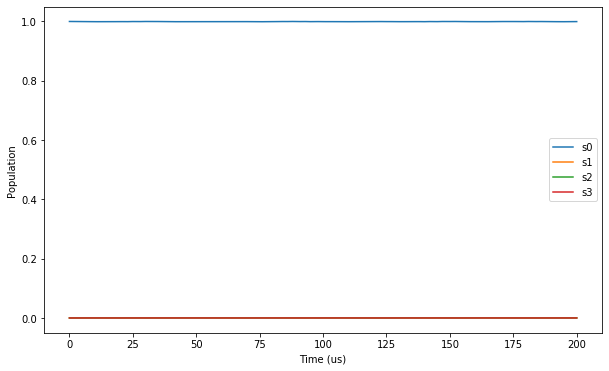

detuning is  -5.305959999999686


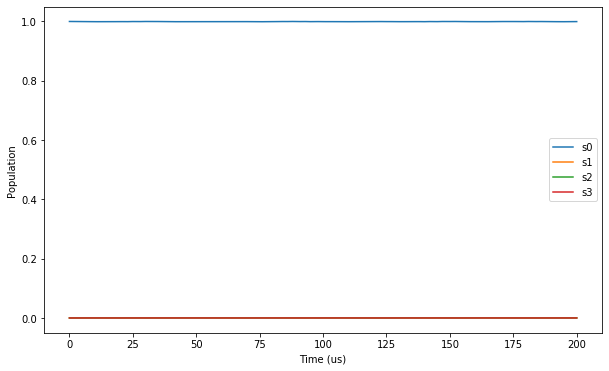

detuning is  -5.134799999999814


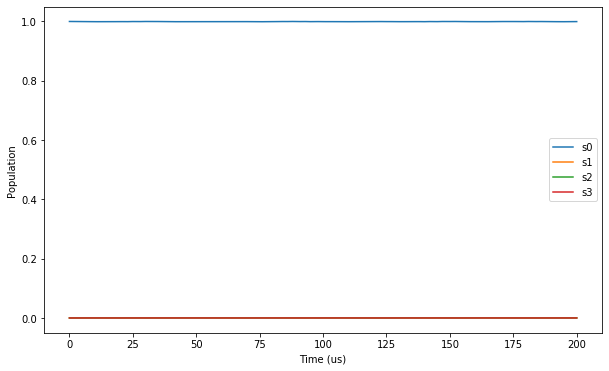

detuning is  -4.963639999999941


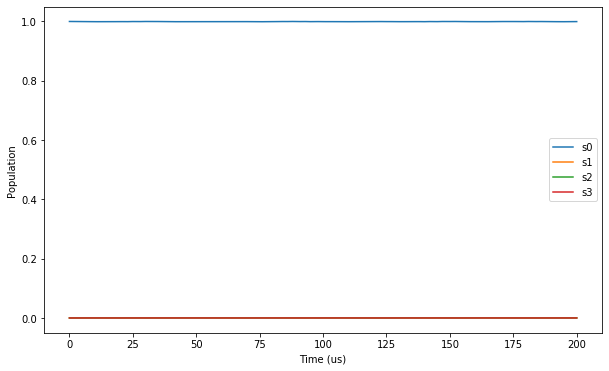

detuning is  -4.792480000000069


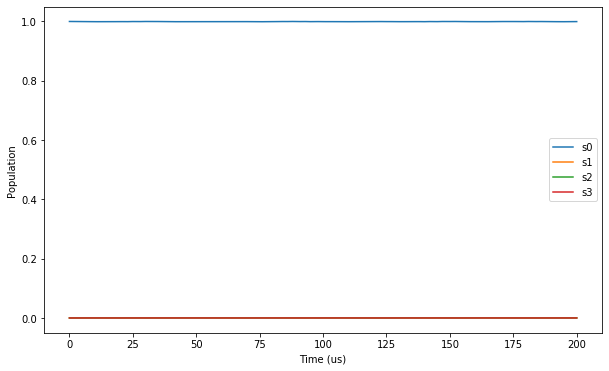

detuning is  -4.621320000000196


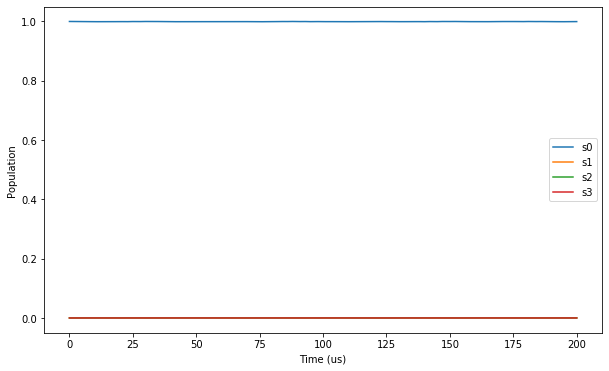

detuning is  -4.450160000000324


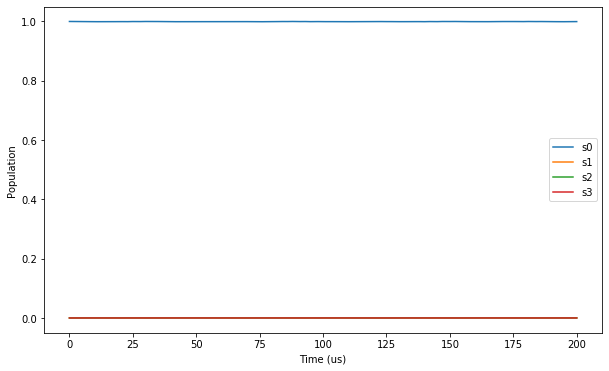

detuning is  -4.279000000000451


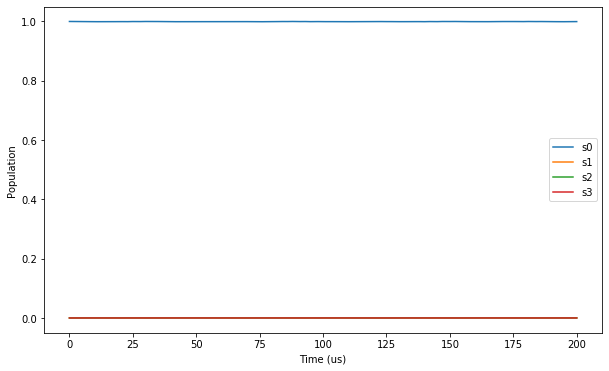

detuning is  -4.107840000000579


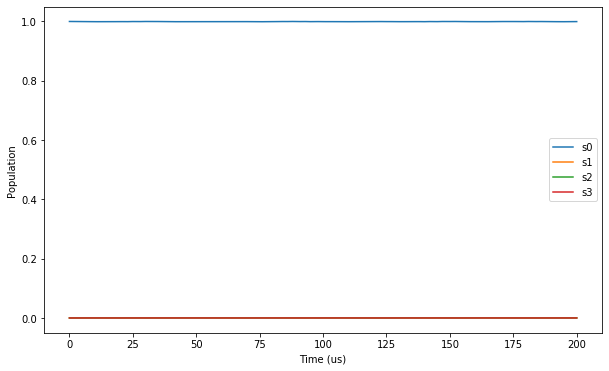

detuning is  -3.936680000000706


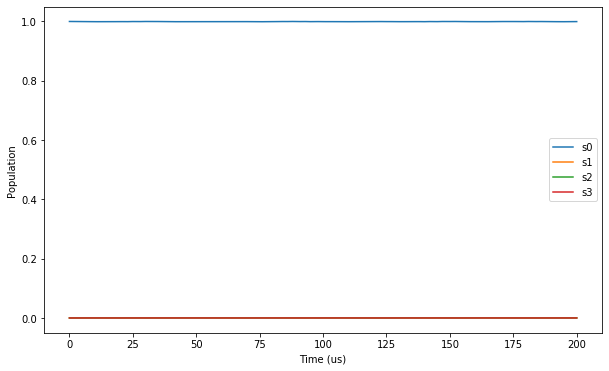

detuning is  -3.7655200000008335


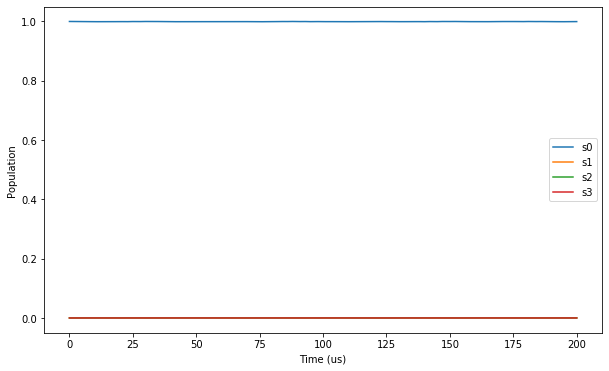

detuning is  -3.594360000000961


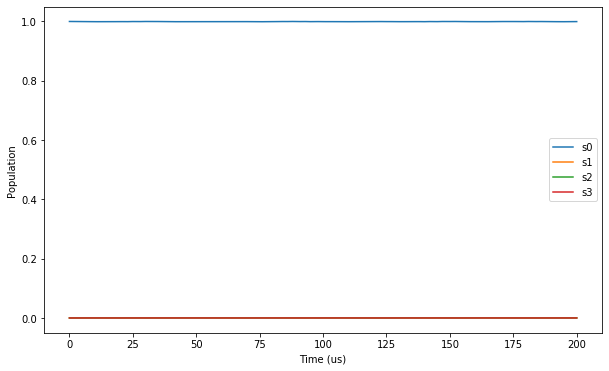

detuning is  -3.4232000000010885


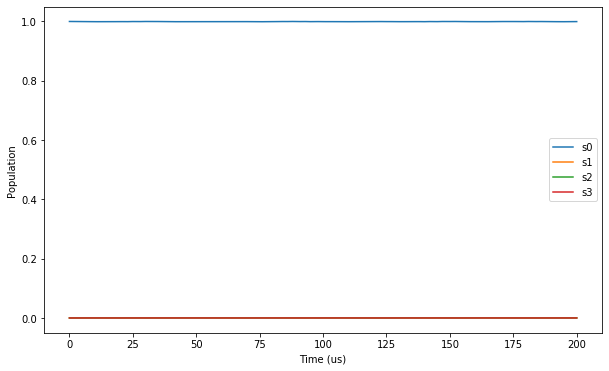

detuning is  -3.252040000001216


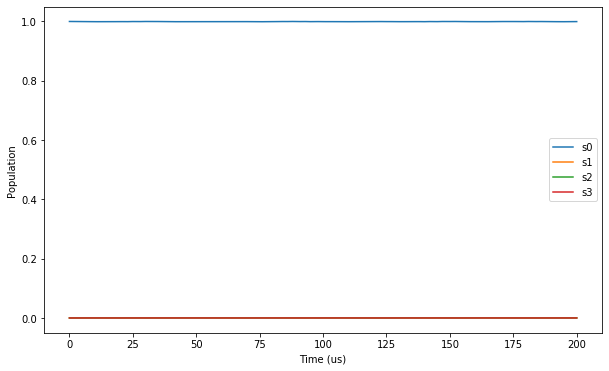

detuning is  -3.0808799999995244


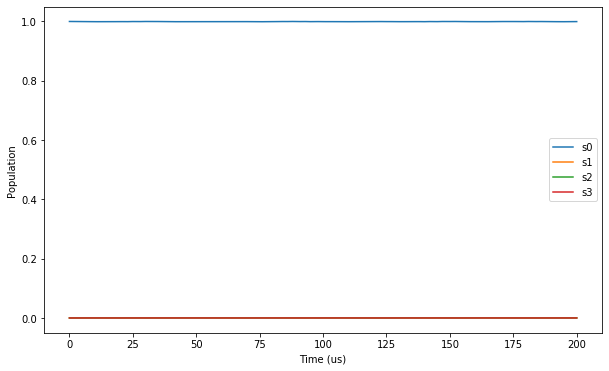

detuning is  -2.909719999999652


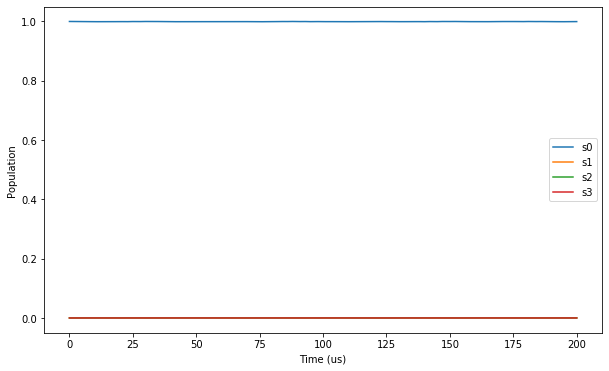

detuning is  -2.7385599999997794


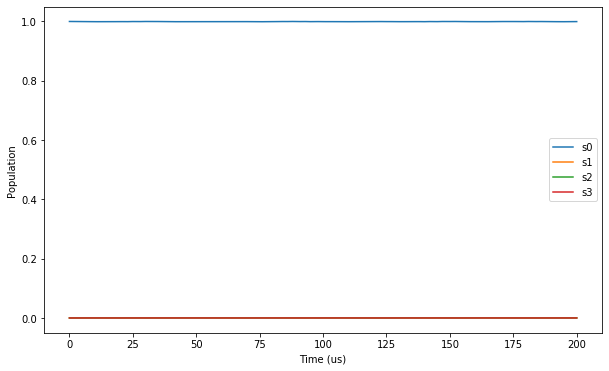

detuning is  -2.567399999999907


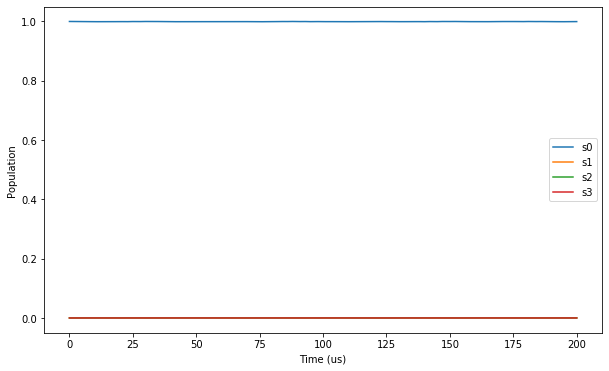

detuning is  -2.3962400000000343


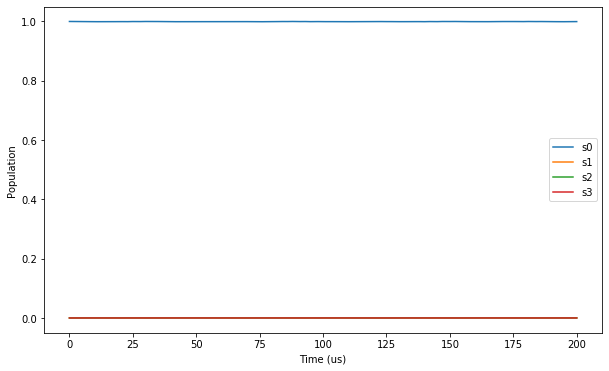

detuning is  -2.225080000000162


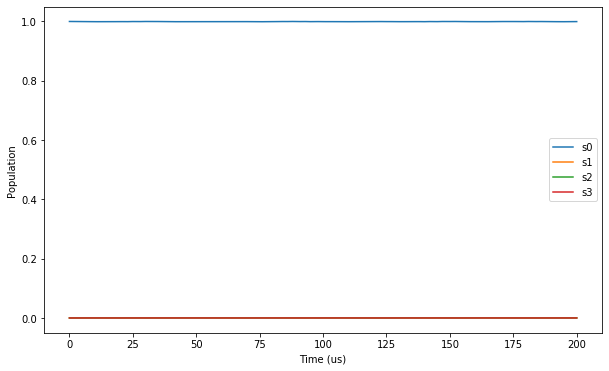

detuning is  -2.0539200000002893


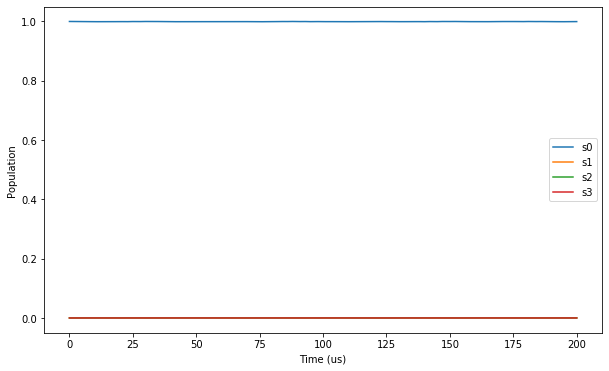

detuning is  -1.8827600000004168


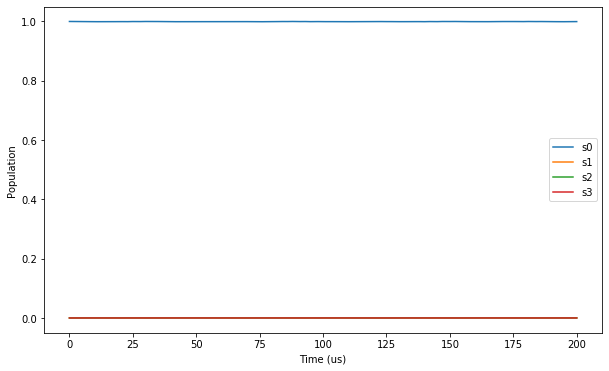

detuning is  -1.7116000000005442


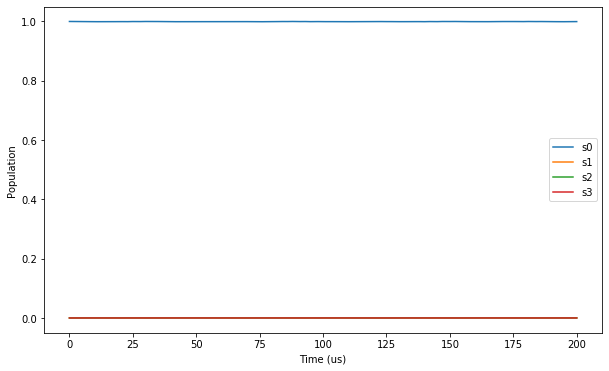

detuning is  -1.5404400000006717


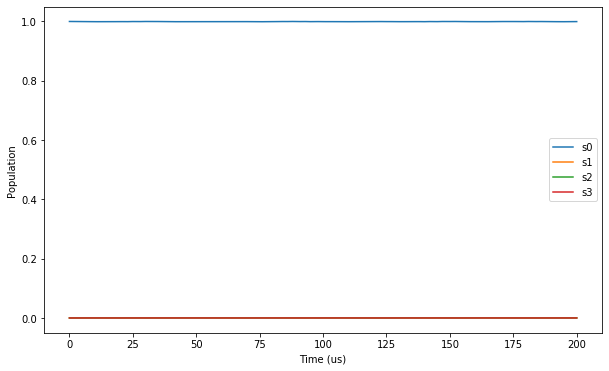

detuning is  -1.3692800000007992


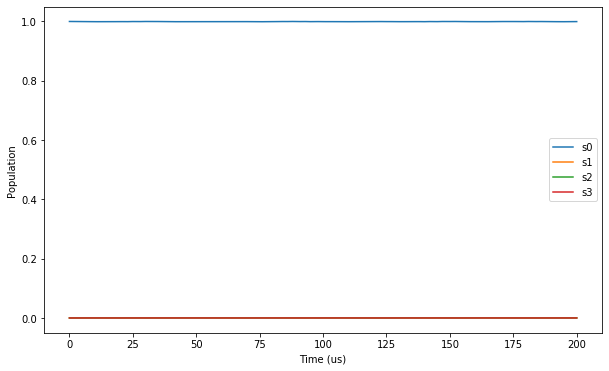

detuning is  -1.1981200000009267


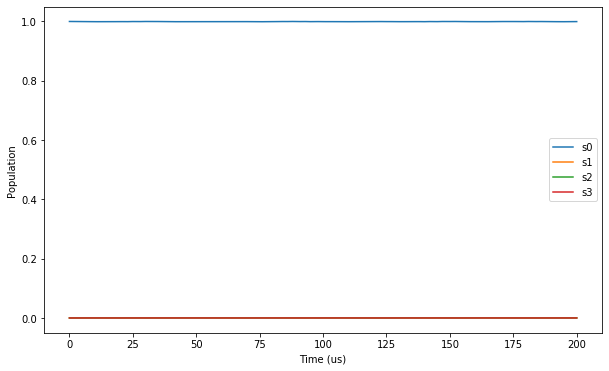

detuning is  -1.0269599999992352


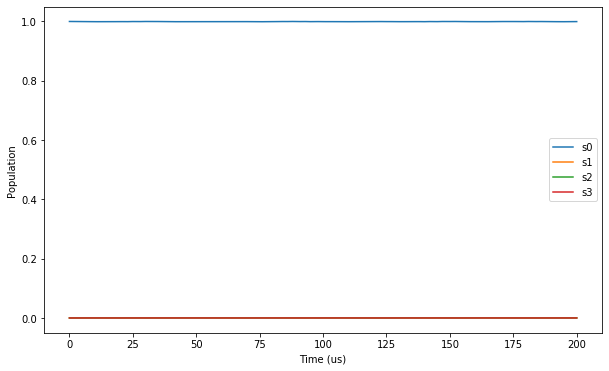

detuning is  -0.8557999999993626


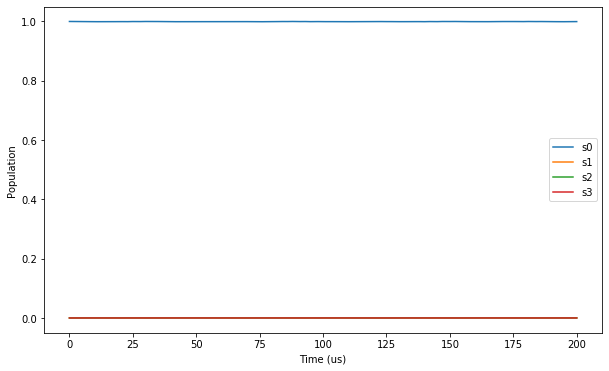

detuning is  -0.6846399999994901


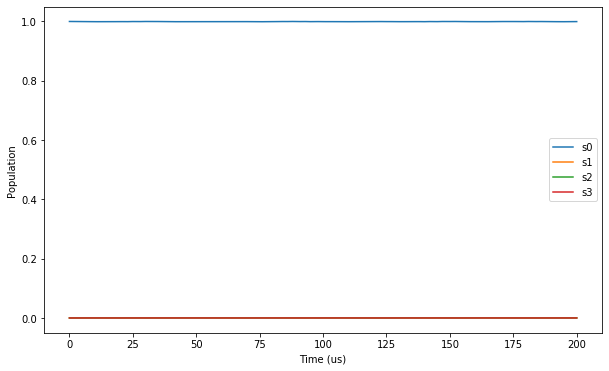

detuning is  -0.5134799999996176


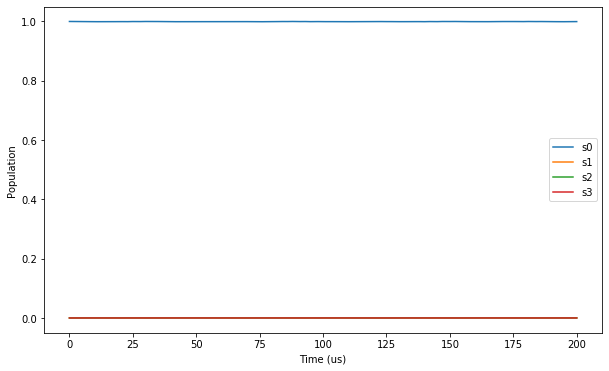

detuning is  -0.34231999999974505


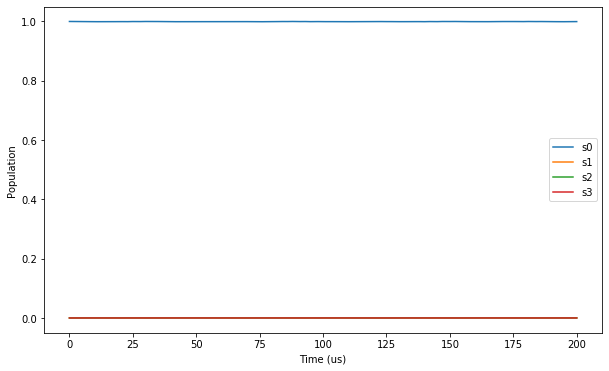

detuning is  -0.17115999999987253


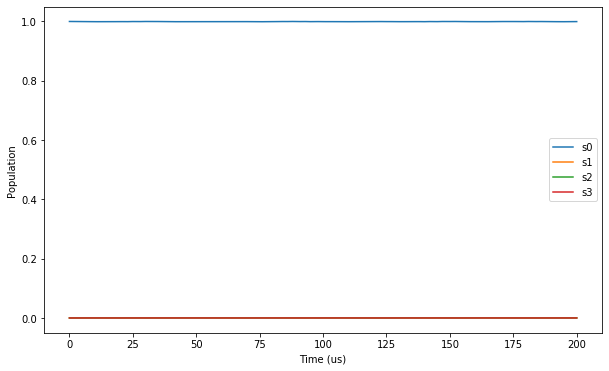

detuning is  0.0


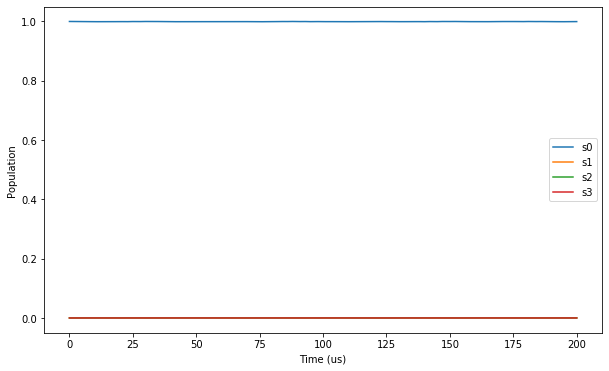

detuning is  0.17115999999987253


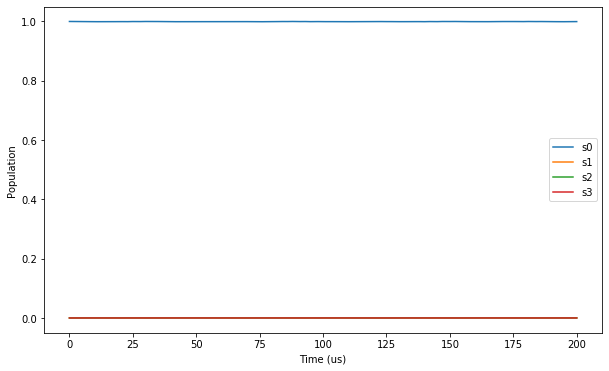

detuning is  0.34231999999974505


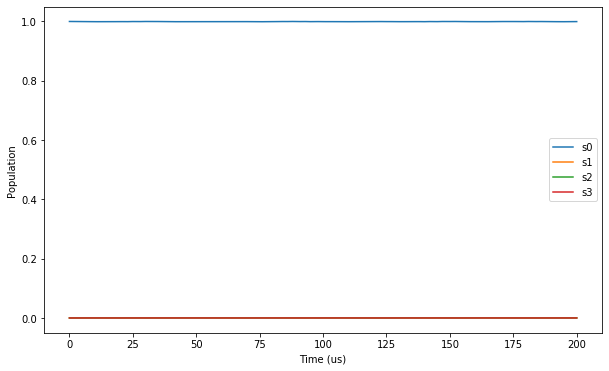

detuning is  0.5134799999996176


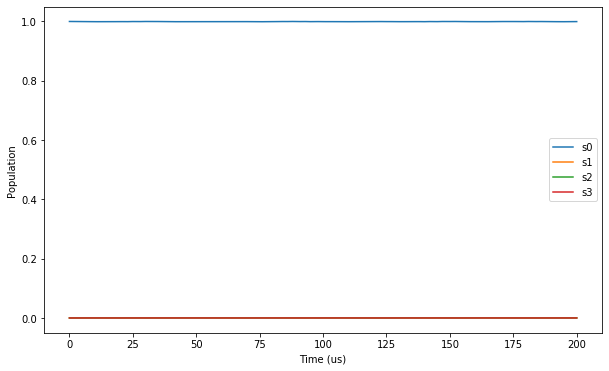

detuning is  0.6846399999994901


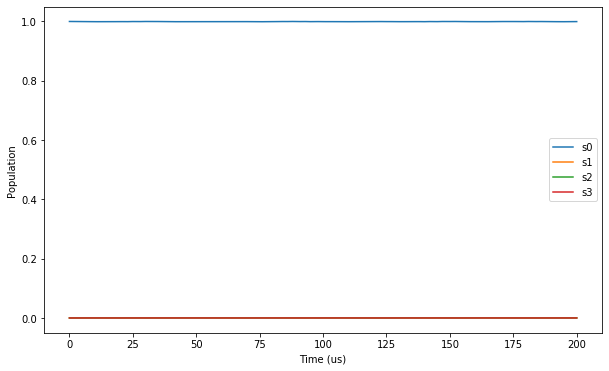

detuning is  0.8557999999993626


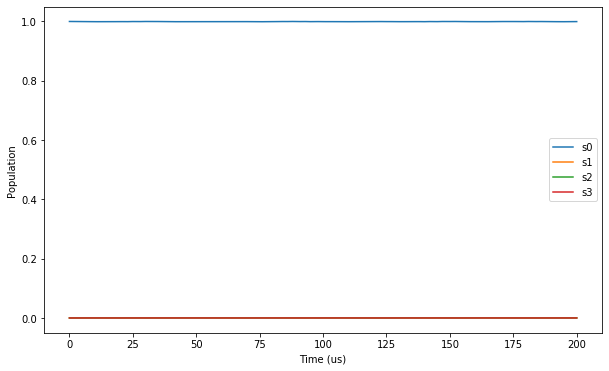

detuning is  1.0269599999992352


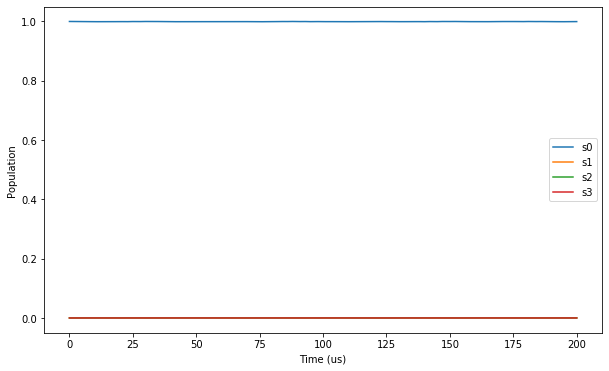

detuning is  1.1981200000009267


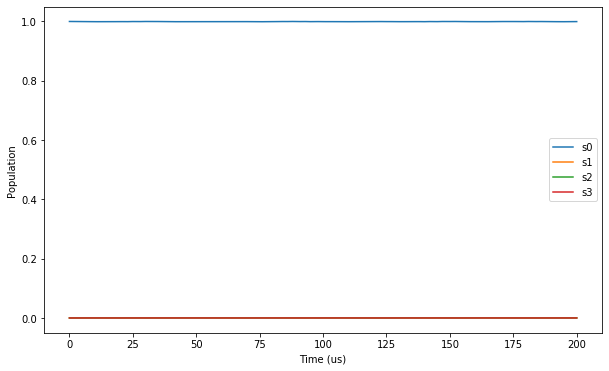

detuning is  1.3692800000007992


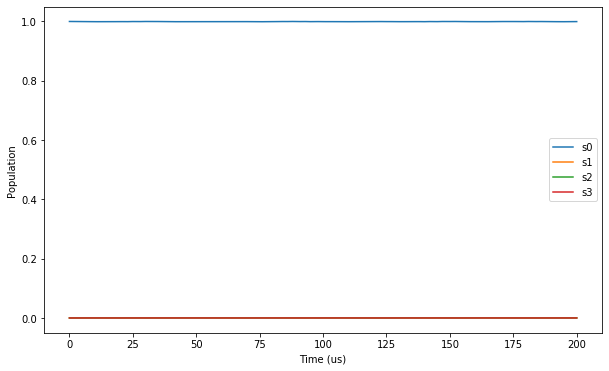

detuning is  1.5404400000006717


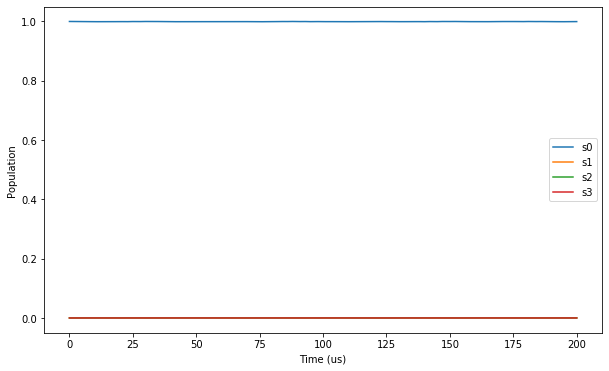

detuning is  1.7116000000005442


KeyboardInterrupt: 

In [63]:
pi_time = 12.5 # us
omega = 1/pi_time # MHz
w01 = 12.628e3 # MHz
delta2 = 7.78
delta3 = 7.78
# w1 = w01-delta2
w2 = delta2
Delta1 = w01-w1
Delta2 = delta2-w2
Delta3 = delta3+w2
E0 = 0
E1 = Delta1
E2 = Delta1+Delta2
E3 = Delta1-Delta3
w1_ls = np.linspace(w01-delta3*1.1, w01+delta2*1.1, 21)
for w1 in w1_ls:
    print('detuning is ', w1-w01)
    exp = DressedState(E0 = E0,
                 E1 = E1,
                 E2 = E2,
                 E3 = E3,
                 w1 = w1,
                 w2 = w2,
                 omega01 = omega,
                 omega02 = omega,
                 omega03 = omega,
                 omega12 = omega,
                 omega13 = omega,
                 gamma1 = 0,
                 gamma2 = 0,
                 gamma3 = 0,
                 s_init = ket2dm(basis(4,0)))
#     s0,s1,s2,s3 = exp.time_scan(0, 200, 201, isPlot = True)
    exp.time_scan(0, 200, 201, isPlot = True)

12628.17116


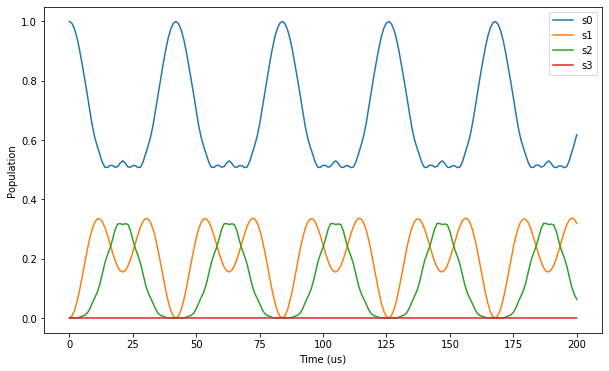

In [68]:
pi_time = 12.5 # us
omega = 1/pi_time # MHz
w01 = 12.628e3 # MHz
delta2 = 7.78
delta3 = 7.78
w1 = w1_ls[51]
print(w1)
w2 = delta2
Delta1 = w01-w1
Delta2 = delta2-w2
Delta3 = delta3+w2
E0 = 0
E1 = Delta1
E2 = Delta1+Delta2
E3 = Delta1-Delta3
exp = DressedState(E0 = E0,
             E1 = E1,
             E2 = E2,
             E3 = E3,
             w1 = w1,
             w2 = w2,
             omega01 = omega,
             omega02 = omega,
             omega03 = omega,
             omega12 = omega,
             omega13 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,0)))
s0,s1,s2,s3 = exp.time_scan(0, 200, 201, isPlot = True)

# Initial state 2

Text(0, 0.5, 'Population')

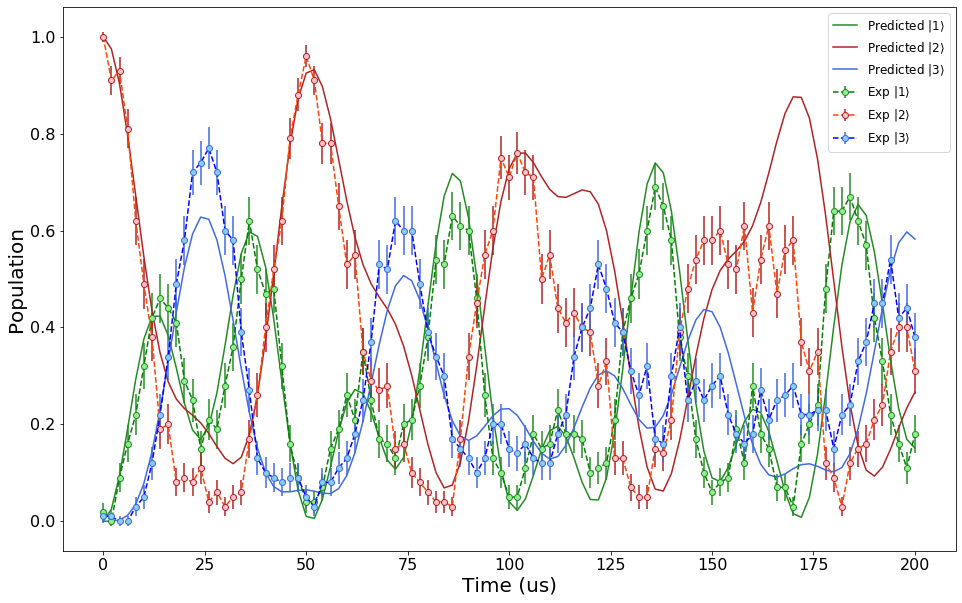

In [94]:
pi_time = 12.5 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 1.0e-1, # MHz
             w3 = 0, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,2)))
s0,s1,s2,s3 = exp.time_scan(0, 200, 101, isPlot = False)

i = 1
x, Prob1_inv = readFile(df_data['state 1'][i])
x, Prob2_inv = readFile(df_data['state 2'][i])
x, Prob3_inv = readFile(df_data['state 3'][i])
Prob1 = 1-Prob1_inv
Prob2 = 1-Prob2_inv
Prob3 = 1-Prob3_inv
err_Prob1 = error(Prob1)
err_Prob2 = error(Prob2)
err_Prob3 = error(Prob3)

plt.figure(figsize = [16,10])
plt.errorbar(x, Prob1, err_Prob1,
             ls='--',color = 'green', marker='o',mec='forestgreen', ecolor='forestgreen',mfc='lightgreen', 
                 label = r'Exp $|1\rightangle$')
plt.plot(x, s1, '-', color = 'forestgreen', label = r'Predicted $|1\rightangle$')
plt.errorbar(x, Prob2, err_Prob2,
         ls='--',color = 'orangered', marker='o',mec='firebrick', ecolor='firebrick',mfc='pink', 
             label = r'Exp $|2\rightangle$')
plt.plot(x, s2, '-', color = 'firebrick', label = r'Predicted $|2\rightangle$')
plt.errorbar(x, Prob3, err_Prob3,
         ls='--',color = 'blue', marker='o',mec='royalblue', ecolor='royalblue',mfc='skyblue',
             label = r'Exp $|3\rightangle$')
plt.plot(x, s3, '-', color = 'royalblue', label = r'Predicted $|3\rightangle$')
plt.legend()
plt.xlabel('Time (us)')
plt.ylabel('Population')

In [110]:
eigen = [[-0.529813, -0.831133, -0.168867], [-0.529813, 0.168867, 0.831133], [-0.662266, 0.529813, -0.529813]]

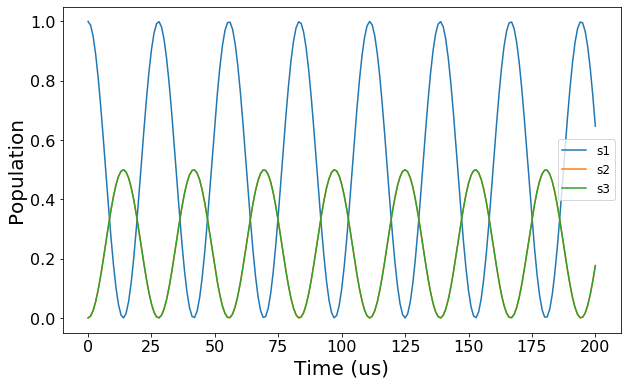

In [129]:
ii = 1
pi_time = 12.5 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 0e-1, # MHz
             w3 = 0e-1, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,1))
#              s_init = ket2dm((eigen[ii][0]*basis(4,1)+eigen[ii][1]*basis(4,2)+eigen[ii][2]*basis(4,3))
#                              /np.sqrt(eigen[ii][0]**2+eigen[ii][1]**2+eigen[ii][2]**2))
            )
s0,s1,s2,s3 = exp.time_scan(0, 200, 201, isPlot = True)

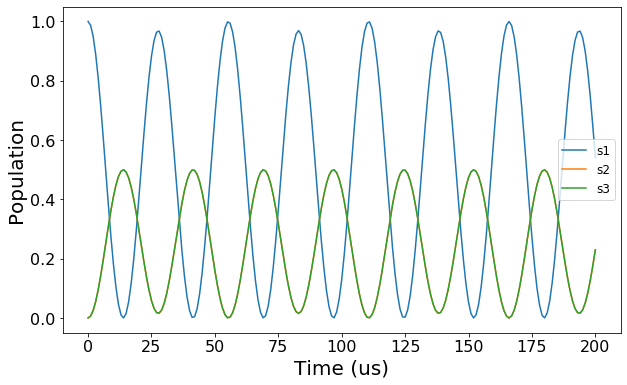

In [131]:
ii = 1
pi_time = 12.5 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 1.0e-2, # MHz
             w3 = -1.0e-2, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,1))
#              s_init = ket2dm((eigen[ii][0]*basis(4,1)+eigen[ii][1]*basis(4,2)+eigen[ii][2]*basis(4,3))
#                              /np.sqrt(eigen[ii][0]**2+eigen[ii][1]**2+eigen[ii][2]**2))
            )
s0,s1,s2,s3 = exp.time_scan(0, 200, 201, isPlot = True)

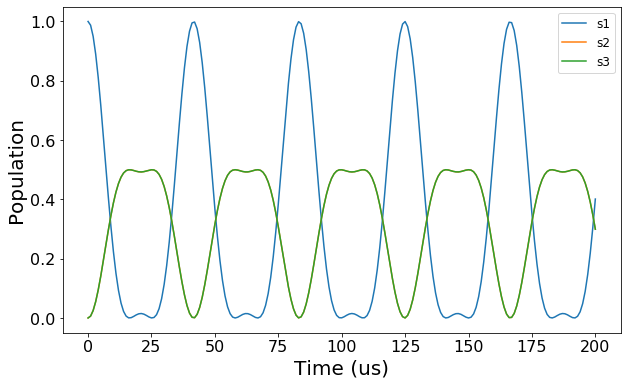

In [140]:
ii = 1
pi_time = 12.5 # us
omega = 1/pi_time # MHz
exp = Zeeman(w0 = 0,
             w1 = 0,
             w2 = 1.0e-1, # MHz
             w3 = -1.0e-1, # MHz
             omega1 = omega,
             omega2 = omega,
             gamma1 = 0,
             gamma2 = 0,
             gamma3 = 0,
             s_init = ket2dm(basis(4,1))
#              s_init = ket2dm((eigen[ii][0]*basis(4,1)+eigen[ii][1]*basis(4,2)+eigen[ii][2]*basis(4,3))
#                              /np.sqrt(eigen[ii][0]**2+eigen[ii][1]**2+eigen[ii][2]**2))
            )
s0,s1,s2,s3 = exp.time_scan(0, 200, 201, isPlot = True)

In [86]:
rx(np.pi)

/Users/sunke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  """Entry point for launching an IPython kernel.


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[6.123234e-17+0.j 0.000000e+00-1.j]
 [0.000000e+00-1.j 6.123234e-17+0.j]]

In [90]:
Rx1 = Qobj([[1/np.sqrt(2),-1j*1/np.sqrt(2),0],[-1j*1/np.sqrt(2),1/np.sqrt(2),0],[0,0,0]])

In [103]:
Rx2 = basis(3,0)*basis(3,2).dag()+basis(3,2)*basis(3,0).dag()+basis(3,1)*basis(3,1).dag()

In [104]:
Rx2

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]

In [105]:
Rx1*basis(3,0)

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.70710678+0.j        ]
 [0.        -0.70710678j]
 [0.        +0.j        ]]

In [106]:
Rx2*Rx1*basis(3,0)

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.        +0.j        ]
 [0.        -0.70710678j]
 [0.70710678+0.j        ]]